## resnet18 base code

안녕하세요 nlp트랙의 이민준 입니다.  
pretrain된 resnet18을 사용해서 18개의 클래스를 분류하는 베이스라인입니다.  
특별한 스킬 없이 돌리면 얼마나 나올까 해서 돌려봤는데 생각보다 잘 나오는 것 같아요!  
팀원분들 께서 다양한 EDA를 해보고 계신데 부족한 클래스들을 augmentation 해보거나 다른 모델과 ensemble을 해보면 더 올라갈 것 같습니다.

대부분의 코드는 부스트캠프 과정 중 받은 자료가 많습니다.  
제공받은 train 데이터를 train(80%) : valid(20%) 나누어 진행했습니다.  
현재 valid dataset 기준 accr : 0.992, f1(macro) : 0.979 입니다.  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
#import torchtext
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

### dataset 생성
모든 train data의 path를 가져와 라벨링을 했습니다.

In [4]:
def search(dirname, result): # 하위목록의 모든 파일을 찾는 함수
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == '.': # .으로 시작하는 얘들 거름
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1] # 확장자 체크
                if ext:
                    result.append(full_filename)
    except PermissionError:
        pass

In [5]:
all_path = []
search(train_image_dir_path, all_path)

train 데이터의 디렉토리는 2700개로 각각의 7개의 이미지 파일(incorrect, mask1, mask2, mask3, mask4, mask5, normal) 을 곱한 갯수가 나옵니다.

In [6]:
len(all_path) # 2700 * 7

18900

In [7]:
all_path[:10]

['/opt/ml/input/data/train/images/001401_male_Asian_48/normal.jpg',
 '/opt/ml/input/data/train/images/001401_male_Asian_48/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/001401_male_Asian_48/mask3.jpg',
 '/opt/ml/input/data/train/images/001401_male_Asian_48/mask4.jpg',
 '/opt/ml/input/data/train/images/001401_male_Asian_48/mask1.jpg',
 '/opt/ml/input/data/train/images/001401_male_Asian_48/mask5.jpg',
 '/opt/ml/input/data/train/images/001401_male_Asian_48/mask2.jpg',
 '/opt/ml/input/data/train/images/003439_male_Asian_58/normal.jpg',
 '/opt/ml/input/data/train/images/003439_male_Asian_58/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/003439_male_Asian_58/mask3.jpg']

파일의 확장자는 jpg, png, jpeg로 3 종류가 있습니다.  

In [8]:
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts) # jpg, png, jpeg, 다 있음

['.jpg', '.png', '.jpeg']


In [9]:
all_path = sorted(all_path)

라벨링을 하는 함수입니다. 조건에 따라 label에 숫자를 더해주는 식으로 만들었습니다.  

In [10]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    if gender == 'female':
        label += 3
        
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
    
    return label

path, label을 컬럼으로 갖는 dataframe을 생성해줍니다

In [13]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])

train_path_label['label'] = train_path_label_df['path'].map(lambda x : labeling(x))
train_path_label

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


In [12]:
# train_path_label.to_csv('./train_path_label.csv', index=False, encoding='utf-8')

In [14]:
# train_path_label = pd.read_csv('./train_path_label.csv', encoding='utf-8')

dataset을 상속받아 만든 CustomDataset입니다.  
transform은 size를 [512, 384] 로 변형하고, Tensor로 만들고, 정규화를 해주었습니다

In [15]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

    def __len__(self):
        return len(self.X)

In [16]:
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

train, valid를 나누는 부분입니다.  
label의 비율을 유지하면 나눴습니다.

In [17]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_path_label, test_size= 0.2, 
                                shuffle = True, stratify= train_path_label['label'], 
                                random_state = 34)

In [18]:
train.shape, valid.shape

((15120, 2), (3780, 2))

dataloader를 정의했습니다. batchsize는 64로 했고 shuffle을 하였습니다.

In [19]:
BATCH_SIZE = 64

In [20]:
train_dataset = CustomDataset(train, transform)

train_dataloader = DataLoader(train_dataset, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True
                       )

In [21]:
valid_dataset = CustomDataset(valid, transform)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True
                             )

dataloader는 [batchsize, channel, height, wide] 를 출력해줍니다

In [22]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

### 모델
모델은 pretrain 된 resnet18을 가져왔습니다.  
이 모델의 마지막 fc 층만 저희의 과제인 18개의 class로 변경해 줍니다.  

In [23]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [24]:
import math

OUTPUT_CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True) # output 18개로

# xavier uniform
torch.nn.init.xavier_uniform_(resnet18.fc.weight) 
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

resnet18.fc.weight.shape[0]

18

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

아래의 대부분의 코드가 부스트캠프에서 학습자료나 과제로 제공받았던 코드를 거의 그대로 사용했습니다.  
설명도 주석으로 잘 달려있어서 그대로 가져왔습니다.  

epoch는 5, lr은 0.0001로 주었습니다.  
차 후에 lr scheduler로 lr을 변경해보는 방법도 좋을 것 같습니다  

In [27]:
resnet18.to(device)

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 5 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션


loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

In [28]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = resnet18(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

        # 한 epoch이 모두 종료되었을 때,
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.505, 평균 Accuracy : 0.859
현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.185, 평균 Accuracy : 0.940
현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.081, 평균 Accuracy : 0.980
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.066, 평균 Accuracy : 0.981
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.019, 평균 Accuracy : 0.997
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.063, 평균 Accuracy : 0.981
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.010, 평균 Accuracy : 0.999
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.057, 평균 Accuracy : 0.981
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 1.000
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.034, 평균 Accuracy : 0.992
학습 종료!
최고 accuracy : 0.9920635223388672, 최고 낮은 loss : 0.03352943774332445


loss는 계속 떨어지고 있어서 epoch을 늘려 학습해봐도 좋을 것 같습니다.  


valid data 기준 99프로의 정확도를 보여줍니다.  
아마 실제 test 데이터는 train이나 valid와 많이 다를것으로 생각됩니다.  

In [29]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0,0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1) # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        #model.train()
    return val_accr

In [30]:
func_eval(resnet18, valid_dataloader, device)

0.9920634920634921

실제 정답과 pred를 비교해보려고 path, pred, target을 dataframe으로 만들었습니다

In [31]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)

            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [32]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)

check_eval_df = check_eval(valid, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/003403_male_As...,1,1
1,/opt/ml/input/data/train/images/000735_female_...,4,4
2,/opt/ml/input/data/train/images/006365_male_As...,6,6
3,/opt/ml/input/data/train/images/003434_male_As...,1,1
4,/opt/ml/input/data/train/images/001603_male_As...,0,0
...,...,...,...
3775,/opt/ml/input/data/train/images/004321_female_...,16,16
3776,/opt/ml/input/data/train/images/004088_female_...,5,5
3777,/opt/ml/input/data/train/images/001490_female_...,4,4
3778,/opt/ml/input/data/train/images/005026_male_As...,2,2


잘못 예측한 데이터만 모아봤습니다.

In [33]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/000225_female_...,4,3
1,/opt/ml/input/data/train/images/000685_male_As...,7,6
2,/opt/ml/input/data/train/images/001024-1_femal...,10,9
3,/opt/ml/input/data/train/images/003414_male_As...,7,1
4,/opt/ml/input/data/train/images/001490_female_...,17,16
5,/opt/ml/input/data/train/images/005210_male_As...,1,0
6,/opt/ml/input/data/train/images/000225_female_...,16,15
7,/opt/ml/input/data/train/images/005459_male_As...,13,14
8,/opt/ml/input/data/train/images/005033_male_As...,7,8
9,/opt/ml/input/data/train/images/001235_male_As...,6,0


틀린 데이터들을 살펴보기 위해 이미지와 같이 출력을 해보겠습니다.

In [51]:
def draw_(df):
    plt.figure(figsize = (15,30))
    row = 7
    for i in range(df.shape[0]):
        plt.subplot(row + 1, df.shape[0]//row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target:{df['target'][i]} , pred:{df['pred'][i]}", color = 'r', size=20)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

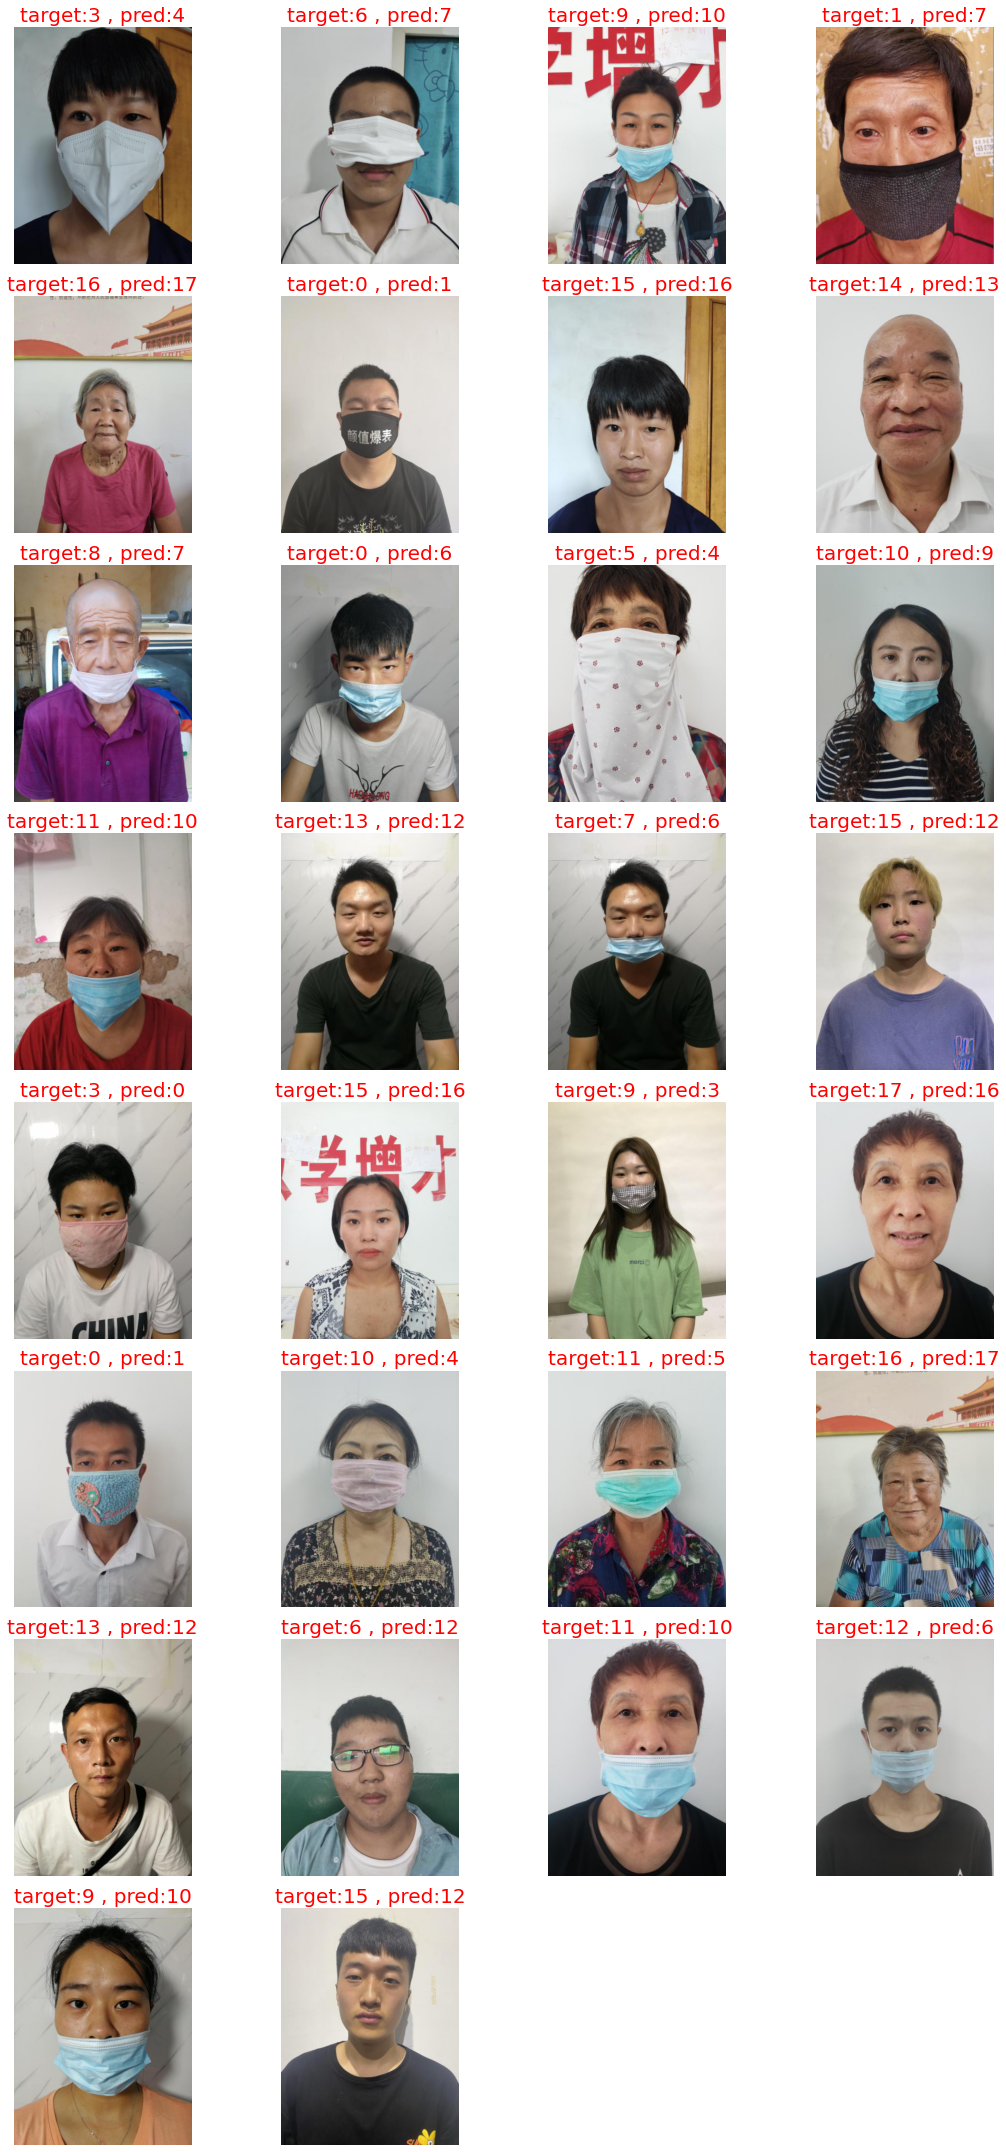

In [52]:
draw_(wrong_df)

아직 분석을 해보진 않았지만 나이를 틀린 데이터들이 꽤 있는것 같습니다.  
저희 과제의 데이터는 incorrect와 normal데이터가 마스크를 쓴 데이터보다 적습니다.  
틀린 데이터들을 보면 incorrect와 normal이 더 많은 걸 볼 수 있습니다.  
부족한 데이터위주로 agmentation 해보는게 좋을 것 같습니다!

f1을 높이려면 precision과 recall 둘다 높여야 하기에 이 둘을 비교해보는 것도 좋을 것 같습니다.

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average = 'macro')

0.9792232597048588

### make submission

In [54]:
test_dir = '/opt/ml/input/data/eval'

In [56]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [58]:
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])
test_dataset = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

resnet18.eval()
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in test_loader:
    with torch.no_grad():
        images = images.to(device)
        pred = resnet18(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv('./submission.csv', index=False)